In [1]:
#imports
# from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
import acquire as a
import zillow as z
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

# 1.) Use DBSCAN to detect anomalies in other products from the customers dataset. The database name is grocery_db.

In [2]:
df = a.get_grocery_data()

In [3]:
df.head()

,customer_id,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0,2,3,12669,9656,7561,214,2674,1338
1,1,2,3,7057,9810,9568,1762,3293,1776
2,2,2,3,6353,8808,7684,2405,3516,7844
3,3,1,3,13265,1196,4221,6404,507,1788
4,4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
df = df.set_index('customer_id')

In [5]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [6]:
df.columns = ['channel','region','fresh','milk','grocery','frozen','soap','pepperoni']

In [7]:
df

,channel,region,fresh,milk,grocery,frozen,soap,pepperoni
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867


In [8]:
frozen_soap_pepperoni = df[['frozen','soap','pepperoni']]

In [9]:
frozen_soap_pepperoni.head()

,frozen,soap,pepperoni
customer_id,,,
0,214,2674,1338
1,1762,3293,1776
2,2405,3516,7844
3,6404,507,1788
4,3915,1777,5185


In [10]:
# Make the scaler
scaler = MinMaxScaler()

# Fit the scaler
scaler.fit(frozen_soap_pepperoni)

# Use the scaler
frozen_soap_pepperoni = scaler.transform(frozen_soap_pepperoni)
frozen_soap_pepperoni

array([[0.0031063 , 0.0654272 , 0.02784731],
       [0.02854842, 0.08058985, 0.03698373],
       [0.03911643, 0.08605232, 0.16355861],
       ...,
       [0.00677142, 0.36346267, 0.03888194],
       [0.01664914, 0.00404174, 0.04426366],
       [0.00065742, 0.01161082, 0.00102211]])

In [11]:
# Make the object
dbsc = DBSCAN(eps = .10, min_samples = 20)

# Fit the object
dbsc.fit(frozen_soap_pepperoni)

DBSCAN(eps=0.1, min_samples=20)

In [12]:
# scaled value columns back onto the dataframe
columns = ["frozen", "soap", "pepperoni"]
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(frozen_soap_pepperoni, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])
df.head()

,channel,region,fresh,milk,grocery,frozen,soap,pepperoni,Scaled_frozen,Scaled_soap,Scaled_pepperoni
0,2,3,12669,9656,7561,214,2674,1338,0.003106,0.065427,0.027847
1,2,3,7057,9810,9568,1762,3293,1776,0.028548,0.080590,0.036984
2,2,3,6353,8808,7684,2405,3516,7844,0.039116,0.086052,0.163559
3,1,3,13265,1196,4221,6404,507,1788,0.104842,0.012346,0.037234
4,2,3,22615,5410,7198,3915,1777,5185,0.063934,0.043455,0.108093


In [13]:
# Assign the cluster labels
# Recall that cluster labels don't have inherent meaning
# DBSCAN makes a cluster called -1 that contains the "noise" or outliers
df['labels'] = dbsc.labels_
df.labels.value_counts()

 0    423
-1     17
Name: labels, dtype: int64

In [14]:
df.head(2)

,channel,region,fresh,milk,grocery,frozen,soap,pepperoni,Scaled_frozen,Scaled_soap,Scaled_pepperoni,labels
0,2,3,12669,9656,7561,214,2674,1338,0.003106,0.065427,0.027847,0
1,2,3,7057,9810,9568,1762,3293,1776,0.028548,0.080590,0.036984,0


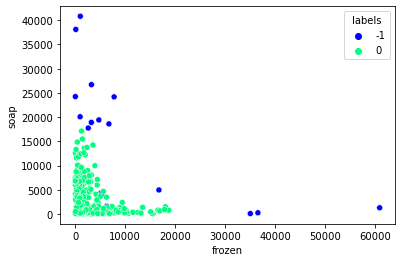

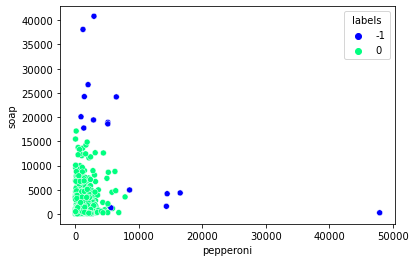

In [15]:
sns.scatterplot(df.frozen, df.soap, hue=df.labels, palette='winter')
plt.show()

sns.scatterplot(df.pepperoni, df.soap, hue=df.labels, palette='winter')
plt.show()

Text(0.5, 0, 'Pepperoni')

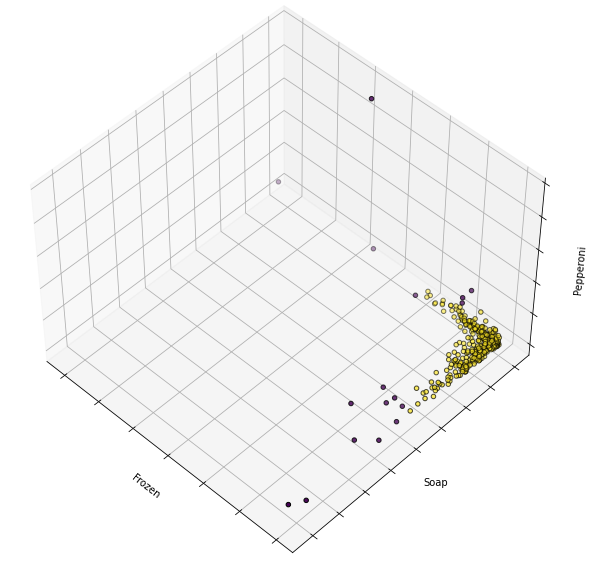

In [16]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(df.frozen, df.soap, df.pepperoni,
           c=df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Frozen')
ax.set_ylabel('Soap')
ax.set_zlabel('Pepperoni')

In [17]:
df.loc[df.labels==-1]

,channel,region,fresh,milk,grocery,frozen,soap,pepperoni,Scaled_frozen,Scaled_soap,Scaled_pepperoni,labels
23,2,3,26373,36423,22019,5154,4337,16523,0.084298,0.106163,0.344597,-1
47,2,3,44466,54259,55571,7782,24171,6465,0.127490,0.592005,0.134793,-1
56,2,3,4098,29892,26866,2616,17740,1340,0.042584,0.434475,0.027889,-1
61,2,3,35942,38369,59598,3254,26701,2017,0.053070,0.653978,0.042011,-1
65,2,3,85,20959,45828,36,24231,1423,0.000181,0.593474,0.029620,-1
71,1,3,18291,1266,21042,5373,4173,14472,0.087897,0.102146,0.301815,-1
85,2,3,16117,46197,92780,1026,40827,2944,0.016452,1.000000,0.061348,-1
86,2,3,22925,73498,32114,987,20070,903,0.015811,0.491549,0.018773,-1
87,1,3,43265,5025,8117,6312,1579,14351,0.103330,0.038605,0.299291,-1
92,2,3,9198,27472,32034,3232,18906,5130,0.052709,0.463036,0.106946,-1


# 2.) Use DBSCAN to detect anomalies in requests from the curriculum access logs in the curriculum_logs database.

In [18]:
# df = a.new_curriculum_logs_data()

In [19]:
# df.date = pd.to_datetime(df.date)

In [20]:
# df

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
847325,2021-04-21,16:41:51,jquery/personal-site,64,28.0,71.150.217.33,28,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2
847326,2021-04-21,16:42:02,jquery/mapbox-api,64,28.0,71.150.217.33,28,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2
847327,2021-04-21,16:42:09,jquery/ajax/weather-map,64,28.0,71.150.217.33,28,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2
847328,2021-04-21,16:44:37,anomaly-detection/discrete-probabilistic-methods,744,28.0,24.160.137.86,28,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2


In [21]:
# df.date = pd.to_datetime(df.date)
# df = df.set_index(df.date)

In [22]:
# df.to_csv('logsql.csv')

In [294]:
df = pd.read_csv('logsql.csv')

In [295]:
df = df.head(1000)

In [296]:
df.shape

(1000, 16)

In [297]:
df.index.shape

(1000,)

In [298]:
df.date = pd.to_datetime(df.date)

In [299]:
df.shape

(1000, 16)

In [300]:
df.index.shape

(1000,)

In [301]:
#df = df.set_index(df.date)

In [302]:
df.shape

(1000, 16)

In [303]:
df.index.shape

(1000,)

In [304]:
codeup = df[["user_id","program_id"]]

In [305]:
codeup.shape

(1000, 2)

In [306]:
# Make the scaler
scaler = MinMaxScaler()

# Fit the scaler
scaler.fit(codeup)

# Use the scaler
codeup = scaler.transform(codeup)
codeup

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [1., 1.],
       [1., 1.],
       [1., 1.]])

In [307]:
codeup

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [1., 1.],
       [1., 1.],
       [1., 1.]])

In [308]:
# Make the object
dbsc = DBSCAN(eps = .10, min_samples = 20)

# Fit the object
dbsc.fit(codeup)

DBSCAN(eps=0.1, min_samples=20)

In [309]:
df.shape

(1000, 16)

In [310]:
df.index.shape

(1000,)

In [311]:
df.index

RangeIndex(start=0, stop=1000, step=1)

In [312]:
# Now, let's add the scaled value columns back onto the dataframe
columns = ['user_id','program_id']
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
#original_df = df.copy()


In [313]:
# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(codeup, columns=scaled_columns)



In [314]:
scaled_df.shape

(1000, 2)

In [315]:
df.index.shape

(1000,)

In [316]:
scaled_df.index

RangeIndex(start=0, stop=1000, step=1)

In [317]:
df.index

RangeIndex(start=0, stop=1000, step=1)

In [318]:
# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index, how='left')
df = df.drop(columns=['key_0'])
df = df.drop(columns=['date.1'])
df

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id,Scaled_user_id,Scaled_program_id
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1,0.000000,0.0
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1,0.000000,0.0
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1,0.000000,0.0
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1,0.000000,0.0
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,NaN,2,0.018519,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2018-01-29,09:20:04,appendix,33,21.0,97.105.19.61,21,Sequoia,#sequoia,2017-09-27,2018-02-15,2017-09-27 20:22:41,2017-09-27 20:22:41,NaN,2,0.592593,1.0
996,2018-01-29,09:20:12,git/branching,33,21.0,97.105.19.61,21,Sequoia,#sequoia,2017-09-27,2018-02-15,2017-09-27 20:22:41,2017-09-27 20:22:41,NaN,2,0.592593,1.0
997,2018-01-29,09:24:51,/,55,21.0,97.105.19.61,21,Sequoia,#sequoia,2017-09-27,2018-02-15,2017-09-27 20:22:41,2017-09-27 20:22:41,NaN,2,1.000000,1.0
998,2018-01-29,09:25:03,spring/fundamentals/views,55,21.0,97.105.19.61,21,Sequoia,#sequoia,2017-09-27,2018-02-15,2017-09-27 20:22:41,2017-09-27 20:22:41,NaN,2,1.000000,1.0


In [319]:
df.shape

(1000, 17)

In [320]:
df['labels'] = dbsc.labels_
df.labels.value_counts()

 0    901
 1     68
-1     31
Name: labels, dtype: int64

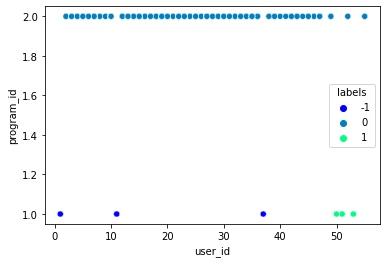

In [321]:
sns.scatterplot(df.user_id, df.program_id, hue=df.labels, palette='winter')
plt.show()


In [322]:
#huh, it really does work better on continuous variables...
#Had to use a small sample of the data because my computer will crash

# 3.)Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).

In [2]:
df = z.get_zillow_data()

In [8]:
df = z.prepare_zillow(df)

In [9]:
df

,propertylandusetypeid,parcel_id,id,baths,beds,calculatedbathnbr,sqft,finishedsquarefeet12,fullbathcnt,latitude,...,structure_dollar_sqft_bin,land_dollar_per_sqft,lot_dollar_sqft_bin,bath_bed_ratio,cola,county,los_angeles,orange,ventura,bathsandbeds
0,261.0,14297519,1727539,3.5,4.0,3.5,3100.0,3100.0,3.0,33634931.0,...,0.5,119.300710,0.5,0.875000,0,orange,0,1,0,7.5
1,261.0,17052889,1387261,1.0,2.0,1.0,1465.0,1465.0,1.0,34449266.0,...,0.2,29.730371,0.3,0.500000,0,ventura,0,0,1,3.0
2,261.0,14186244,11677,2.0,3.0,2.0,1243.0,1243.0,2.0,33886168.0,...,0.2,56.865394,0.4,0.666667,0,orange,0,1,0,5.0
3,261.0,12177905,2288172,3.0,4.0,3.0,2376.0,2376.0,3.0,34245180.0,...,0.1,2.778417,0.1,0.750000,0,los_angeles,1,0,0,7.0
6,261.0,12095076,781532,3.0,4.0,3.0,2962.0,2962.0,3.0,34145202.0,...,0.3,7.882841,0.2,0.750000,0,los_angeles,1,0,0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77569,261.0,12412492,2274245,2.0,4.0,2.0,1633.0,1633.0,2.0,33870815.0,...,0.3,47.746868,0.3,0.500000,0,los_angeles,1,0,0,6.0
77571,261.0,11000655,673515,2.0,2.0,2.0,1286.0,1286.0,2.0,34245368.0,...,0.2,5.984685,0.2,1.000000,1,los_angeles,1,0,0,4.0
77572,261.0,17239384,2968375,2.0,4.0,2.0,1612.0,1612.0,2.0,34300140.0,...,0.1,1.364891,0.1,0.500000,0,ventura,0,0,1,6.0
77573,261.0,12773139,1843709,1.0,3.0,1.0,1032.0,1032.0,1.0,34040895.0,...,0.1,3.300946,0.1,0.333333,0,los_angeles,1,0,0,4.0


In [10]:
beds_sqft = df[['beds','sqft']]
beds_sqft.head(2)

,beds,sqft
0,4.0,3100.0
1,2.0,1465.0


In [12]:
# Make
scaler = MinMaxScaler()

# Fit
scaler.fit(beds_sqft)

# Use
beds_sqft = scaler.transform(beds_sqft)
beds_sqft

array([[0.5       , 0.79568151],
       [0.16666667, 0.35438596],
       [0.33333333, 0.29446694],
       ...,
       [0.5       , 0.39406208],
       [0.33333333, 0.23751687],
       [0.33333333, 0.43454791]])

In [13]:
# Make the object
dbsc = DBSCAN(eps = .10, min_samples = 20)

# Fit the object
dbsc.fit(beds_sqft)

DBSCAN(eps=0.1, min_samples=20)

In [15]:
columns = ['beds','sqft']
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(beds_sqft, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])
df.head()

,propertylandusetypeid,parcel_id,id,baths,beds,calculatedbathnbr,sqft,finishedsquarefeet12,fullbathcnt,latitude,...,lot_dollar_sqft_bin,bath_bed_ratio,cola,county,los_angeles,orange,ventura,bathsandbeds,Scaled_beds,Scaled_sqft
0,261.0,14297519,1727539,3.5,4.0,3.5,3100.0,3100.0,3.0,33634931.0,...,0.5,0.875000,0,orange,0,1,0,7.5,0.500000,0.795682
1,261.0,17052889,1387261,1.0,2.0,1.0,1465.0,1465.0,1.0,34449266.0,...,0.3,0.500000,0,ventura,0,0,1,3.0,0.166667,0.354386
2,261.0,14186244,11677,2.0,3.0,2.0,1243.0,1243.0,2.0,33886168.0,...,0.4,0.666667,0,orange,0,1,0,5.0,0.333333,0.294467
3,261.0,12177905,2288172,3.0,4.0,3.0,2376.0,2376.0,3.0,34245180.0,...,0.1,0.750000,0,los_angeles,1,0,0,7.0,0.500000,0.600270
4,261.0,12095076,781532,3.0,4.0,3.0,2962.0,2962.0,3.0,34145202.0,...,0.2,0.750000,0,los_angeles,1,0,0,7.0,0.500000,0.758435


In [16]:
df['labels'] = dbsc.labels_
df.labels.value_counts()

 2    23137
 0    14352
 1     8283
 3     2960
 4      571
 6      368
 5       39
-1       17
Name: labels, dtype: int64

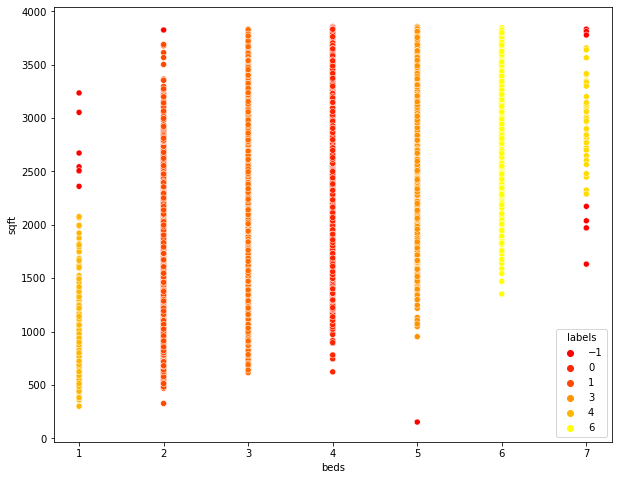

In [21]:
plt.figure(figsize=(10,8))
sns.scatterplot(df.beds, df.sqft, hue=df.labels, palette='autumn')
plt.show()
